In [ ]:
# 安装必要的库
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# 导入库
import cv2
import pytesseract
import csv
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow
import re

In [ ]:
# 挂载Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 视频路径
video_path = '/content/drive/MyDrive/Ventilator Test 1/20250519-121302-v28775-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 2/20250519-075354-v28771-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 3/20250520-131415-v28852-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 4/20250521-070426-v28929-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 5/20250522-082753-v29006-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 6/20250528-110409-v29464-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 7/20250529-120810-v29545-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 8/20250530-111445-v29622-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 9/20250602-075756-v29849-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 10/20250602-115844-v29853-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 11/20250603-071828-v29930-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 12/20250603-105741-v29934-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 13/20250605-073749-v30092-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 14/20250609-132228-v30399-27.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 15/20250611-085608-v30549-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 16/20250611-122313-v30553-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 17/20250616-090340-v30917-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 18/20250616-124624-v30921-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 19/20250617-085020-v30999-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 20/20250619-081602-v31149-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 21/20250623-123112-v31449-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 22/20250625-072122-v31597-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 23/20250625-112723-v31601-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 24/20250626-071256-v31677-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 25/20250626-111734-v31681-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 26/20250627-074121-v31758-110.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 27/20250630-073355-v31977-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 28/20250630-120037-v31981-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 29/20250701-070948-v32057-53.mp4'
# video_path = '/content/drive/MyDrive/Ventilator Test 30/20250701-121203-v32061-53.mp4'

# 打开视频文件
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("无法打开视频文件")

In [ ]:
# 获取视频信息
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_duration = total_frames / fps
hours_total = int(total_duration // 3600)
minutes_total = int((total_duration % 3600) // 60)
seconds_total = int(total_duration % 60)
total_time_str = f"{hours_total:02d}:{minutes_total:02d}:{seconds_total:02d}"

print(f"视频信息:")
print(f"- 每秒帧数(FPS): {fps:.2f}")
print(f"- 总帧数: {total_frames}")
print(f"- 总时长: {total_time_str}")

视频信息:
- 每秒帧数(FPS): 29.97
- 总帧数: 413715
- 总时长: 03:50:04


In [ ]:
# 用户输入处理时间范围
print("\n请输入处理的时间范围 (格式: HH:MM:SS)")
print(f"视频总时长: {total_time_str}")

# 获取开始时间
start_time_input = input("输入开始时间 (直接回车则从视频开头开始): ")
if start_time_input.strip() == "":
    start_sec = 0
    print("使用默认开始时间: 00:00:00")
else:
    try:
        h, m, s = map(int, start_time_input.split(':'))
        start_sec = h * 3600 + m * 60 + s
        if start_sec >= total_duration:
            raise ValueError("开始时间超过视频总时长")
        print(f"开始时间: {h:02d}:{m:02d}:{s:02d} ({start_sec}秒)")
    except Exception as e:
        print(f"输入错误: {str(e)}，将使用视频开头作为开始时间")
        start_sec = 0

# 获取结束时间
end_time_input = input("输入结束时间 (直接回车则处理到视频结束): ")
if end_time_input.strip() == "":
    end_sec = total_duration
    print(f"使用默认结束时间: {total_time_str}")
else:
    try:
        h, m, s = map(int, end_time_input.split(':'))
        end_sec = h * 3600 + m * 60 + s
        if end_sec > total_duration:
            print(f"结束时间超过视频总时长，将使用视频结束时间: {total_time_str}")
            end_sec = total_duration
        elif end_sec <= start_sec:
            raise ValueError("结束时间必须晚于开始时间")
        print(f"结束时间: {h:02d}:{m:02d}:{s:02d} ({end_sec}秒)")
    except Exception as e:
        print(f"输入错误: {str(e)}，将使用视频结束时间")
        end_sec = total_duration

# 计算起始帧和结束帧
start_frame = int(start_sec * fps)
end_frame = min(int(end_sec * fps), total_frames)
frames_to_process = end_frame - start_frame + 1

print(f"\n处理范围:")
print(f"- 起始帧: {start_frame} (时间: {start_sec:.2f}秒)")
print(f"- 结束帧: {end_frame} (时间: {end_sec:.2f}秒)")
print(f"- 处理帧数: {frames_to_process}/{total_frames}")


请输入处理的时间范围 (格式: HH:MM:SS)
视频总时长: 03:50:04
输入开始时间 (直接回车则从视频开头开始): 
使用默认开始时间: 00:00:00
输入结束时间 (直接回车则处理到视频结束): 
使用默认结束时间: 03:50:04

处理范围:
- 起始帧: 0 (时间: 0.00秒)
- 结束帧: 413715 (时间: 13804.12秒)
- 处理帧数: 413716/413715



显示起始帧 (供ROI选择参考):


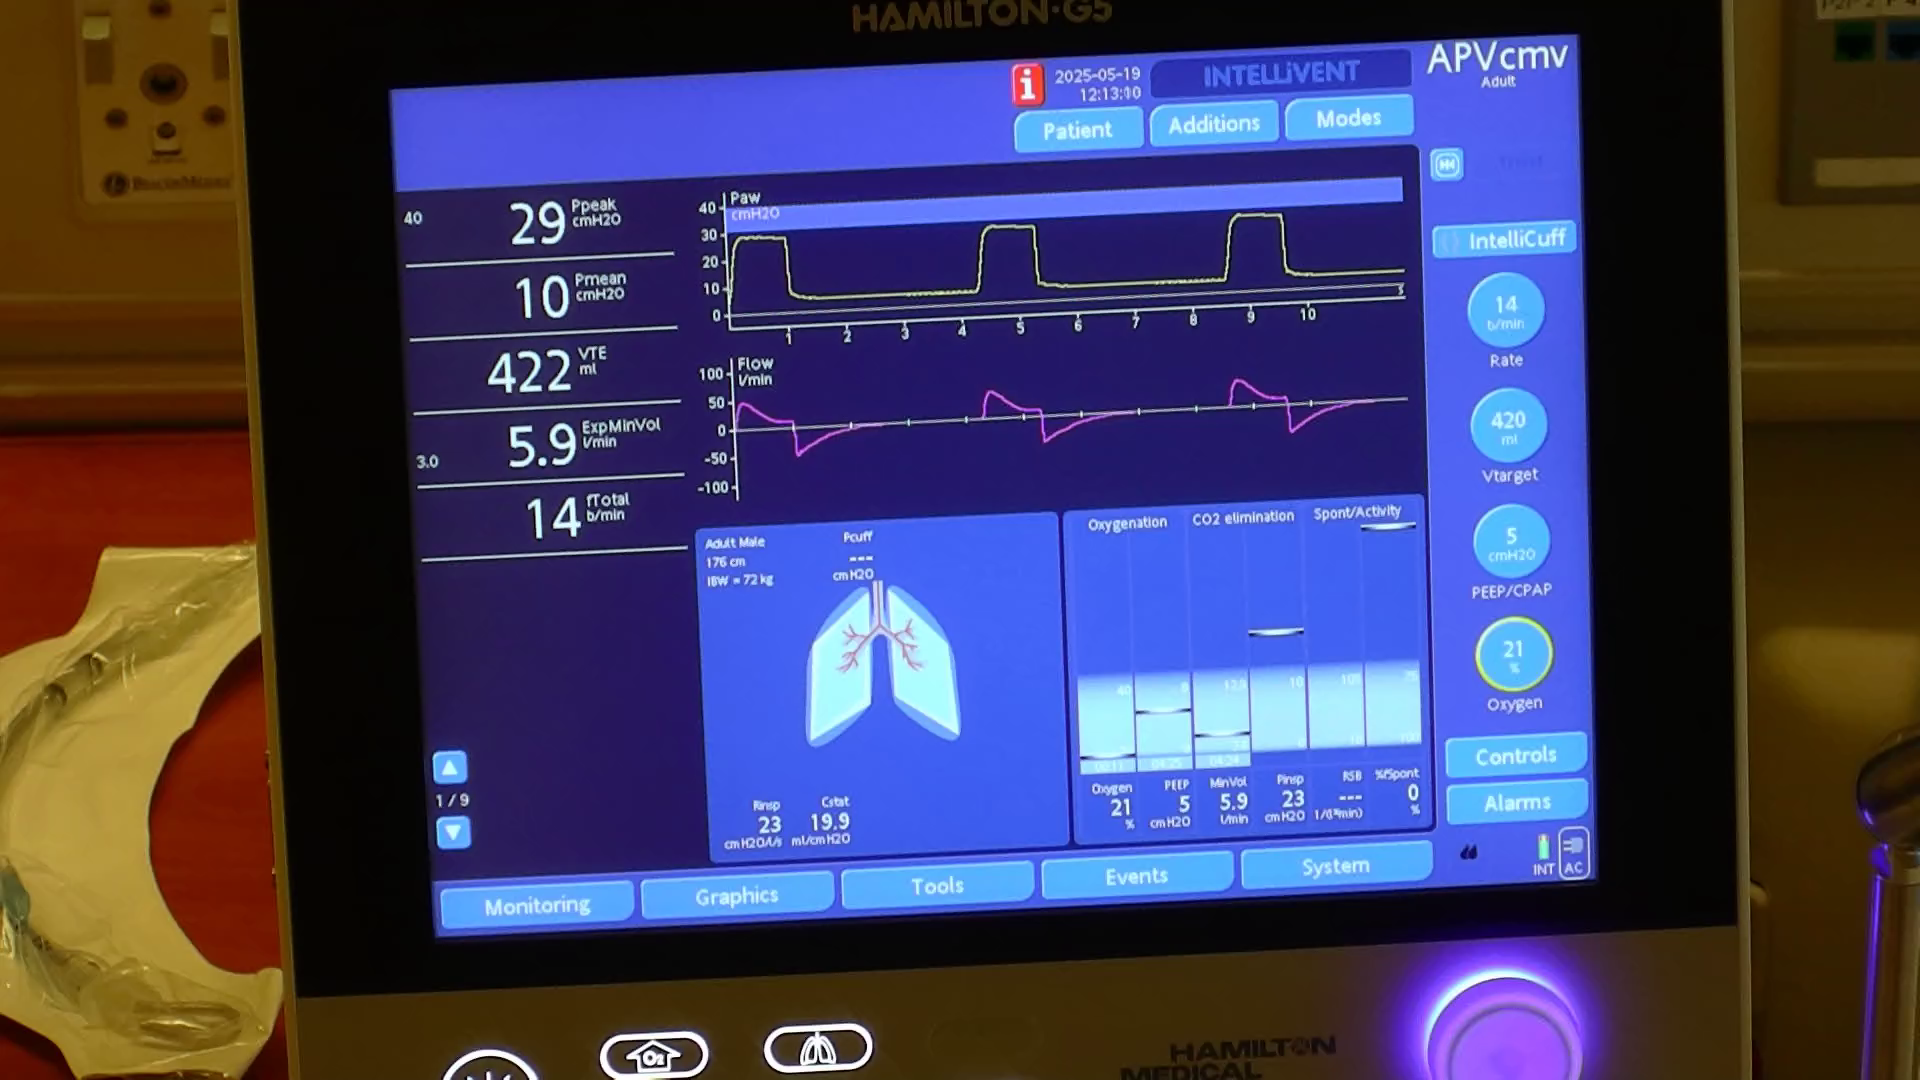

In [ ]:
# 设置视频到起始帧
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# 读取起始帧用于ROI选择
ret, first_frame = cap.read()
if not ret:
    raise ValueError("无法读取起始帧")

# 显示起始帧供参考
print("\n显示起始帧 (供ROI选择参考):")
cv2_imshow(first_frame)


请为两个ROI区域输入坐标 (格式: x1,y1,x2,y2)
示例: 100,200,300,400 表示从(100,200)到(300,400)的矩形
输入第一个ROI坐标: 481,345,578,398
输入第二个ROI坐标: 518,493,584,543

显示带ROI区域的图像 (请确认绿色框位置正确):


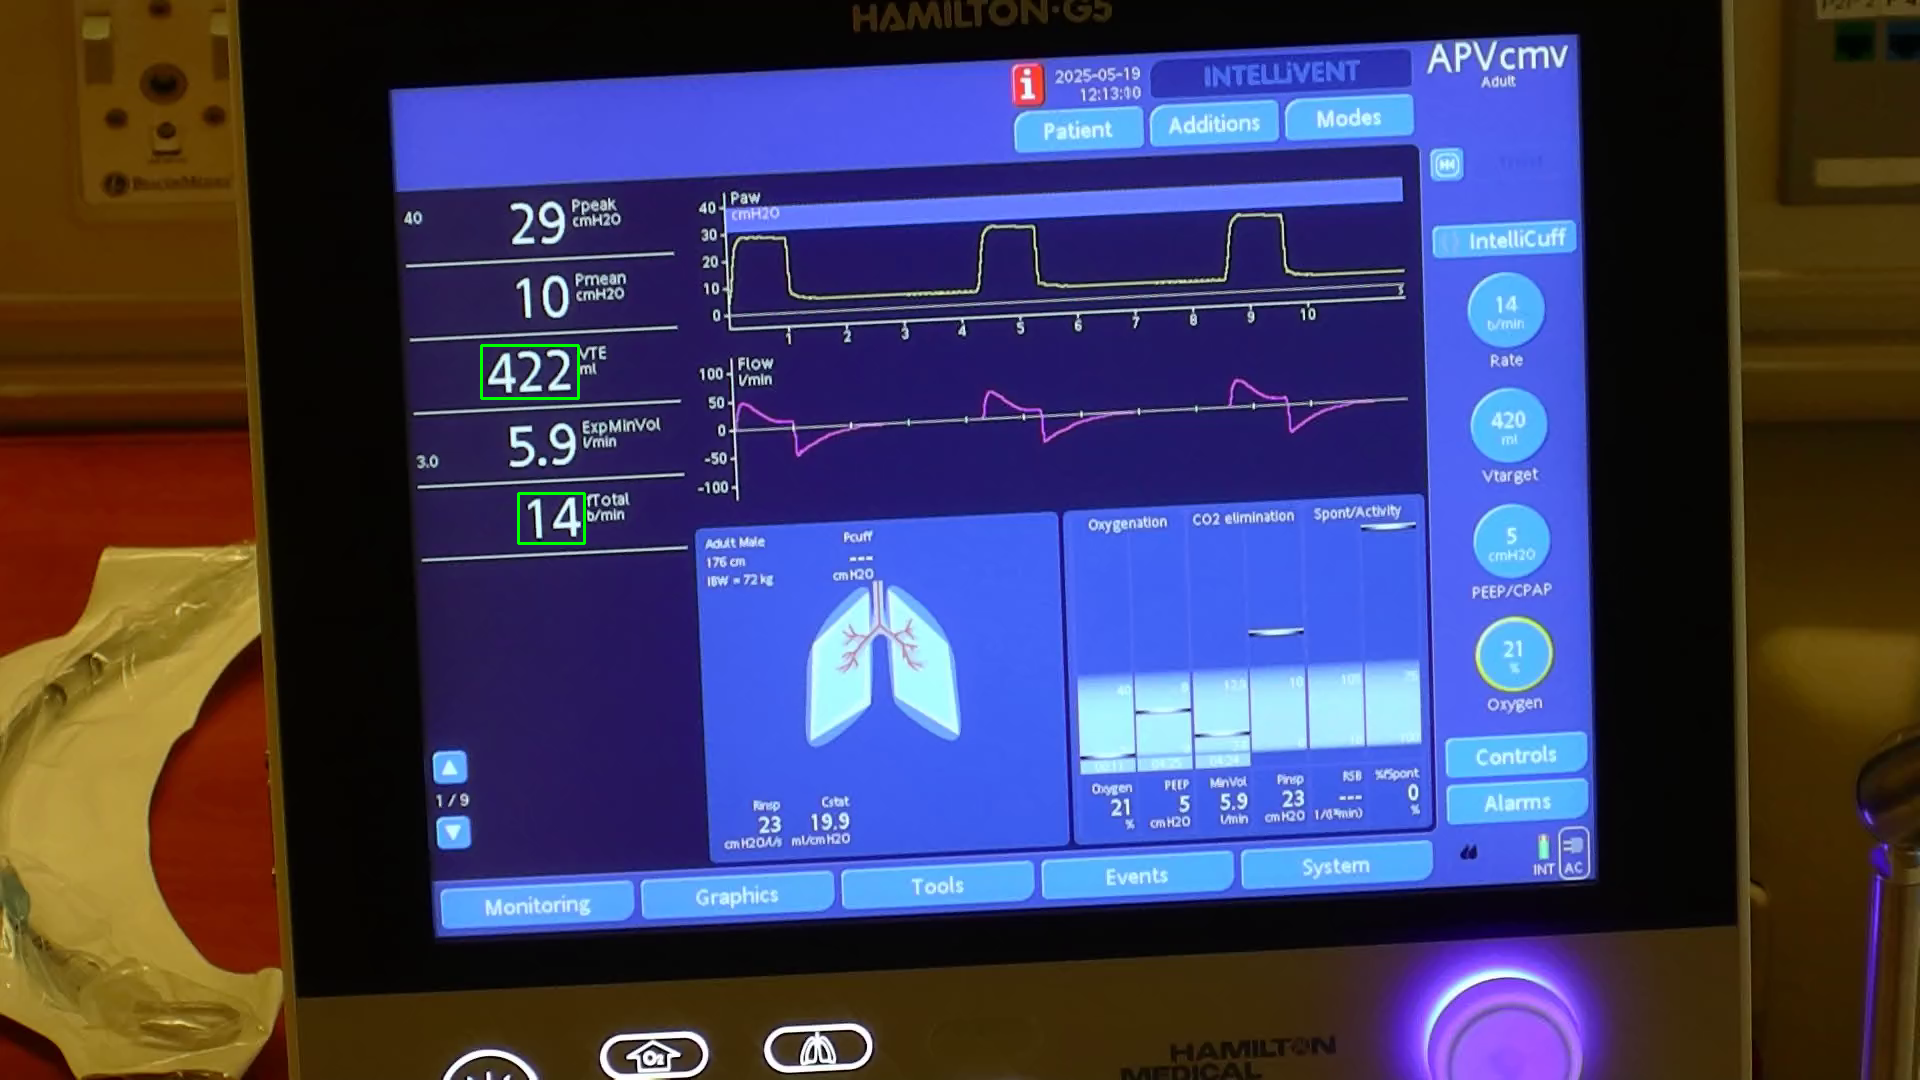

ROI位置已标记为绿色矩形


In [ ]:
# 用户输入ROI坐标
print("\n请为两个ROI区域输入坐标 (格式: x1,y1,x2,y2)")
print("示例: 100,200,300,400 表示从(100,200)到(300,400)的矩形")

roi1_coords = list(map(int, input("输入第一个ROI坐标: ").split(',')))
roi2_coords = list(map(int, input("输入第二个ROI坐标: ").split(',')))

# 验证坐标有效性
def validate_coords(coords, img_shape):
    x1, y1, x2, y2 = coords
    if not (0 <= x1 < x2 <= img_shape[1] and 0 <= y1 < y2 <= img_shape[0]):
        raise ValueError("无效坐标: 坐标超出图像范围或格式错误")

validate_coords(roi1_coords, first_frame.shape)
validate_coords(roi2_coords, first_frame.shape)

# 在图像上绘制ROI区域
roi_frame = first_frame.copy()
cv2.rectangle(roi_frame, (roi1_coords[0], roi1_coords[1]),
              (roi1_coords[2], roi1_coords[3]), (0, 255, 0), 2)
cv2.rectangle(roi_frame, (roi2_coords[0], roi2_coords[1]),
              (roi2_coords[2], roi2_coords[3]), (0, 255, 0), 2)

# 显示带ROI的图像
print("\n显示带ROI区域的图像 (请确认绿色框位置正确):")
cv2_imshow(roi_frame)
print("ROI位置已标记为绿色矩形")

# Video 1
# 481,345,578,398
# 518,493,584,543

# Video 2
# 480,338,583,398
# 522,488,591,540

# Video 3 00:00:00-03:15:47
# 440,321,568,427
# 462,469,580,568

# Video 4
# 459,363,547,415
# 494,507,552,553

# Video 5
# 533,394,620,443
# 568,537,624,584

# Video 6
# 399,398,483,443
# 432,537,486,580

# Video 7 00:00:00-02:17:27
# 545,334,626,381
# 577,465,631,508

# Video 8
# 448,340,535,391
# 481,479,538,529

# Video 9
# 448,340,535,391
# 481,479,538,529

# Video 10
# 448,340,535,391
# 481,479,538,529

# Video 11
# 448,340,535,391
# 479,479,538,529

# Video 12
# 448,340,535,391
# 479,479,538,529

# Video 13 00:00:00-02:49:52
# 529,522,601,565
# 556,637,606,679

# Video 14
# 299,281,496,373
# 349,485,504,556

# Video 15 00:00:00-02:24:19
# 455,335,538,384
# 485,467,543,516

# Video 16
# 455,335,538,384
# 485,467,543,516

# Video 17
# 461,338,548,388
# 492,479,550,528

# Video 18
# 461,338,548,388
# 492,479,550,528

# Video 19
# 455,336,541,385
# 485,476,544,523

# Video 20 00:00:00-03:03:21
# 451,355,547,409
# 486,508,550,559

# Video 21
# 496,354,586,403
# 531,495,591,545

# Video 22
# 493,324,582,374
# 526,465,584,514

# Video 23
# 493,324,582,374
# 526,465,584,514

# Video 24
# 493,350,583,401
# 526,491,587,541

# Video 25
# 493,350,583,401
# 526,491,587,541

# Video 26 00:00:00-02:08:21
# 548,397,636,447
# 573,544,632,593

# Video 26 02:08:26-结尾
# 521,330,615,382
# 547,484,610,538

# Video 27
# 514,324,681,389
# 547,464,682,529

# Video 28
# 511,341,599,390
# 542,481,601,531

# Video 29
# 479,360,568,409
# 510,500,570,549

# Video 30
# 481,363,568,410
# 509,502,569,551

In [ ]:
# OCR处理函数 - 增强错误处理
def extract_digit(roi_image, display=False):
    try:
        # 预处理图像
        gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # 使用Tesseract OCR识别数字
        custom_config = r'--oem 3 --psm 6 outputbase digits'
        text = pytesseract.image_to_string(thresh, config=custom_config)

        # 提取数字 (处理OCR可能识别的非数字字符)
        digits = re.findall(r'\d+', text)

        # 如果需要显示处理过程
        if display:
            # 显示预处理图像
            cv2_imshow(thresh)
            print(f"OCR识别文本: {text}")
            print(f"提取的数字: {digits[0] if digits else '无数字'}")

        return int(digits[0]) if digits else None
    except Exception as e:
        # 发生错误时返回None
        return None

# 提取起始帧的数值作为示例
roi1_sample = first_frame[roi1_coords[1]:roi1_coords[3], roi1_coords[0]:roi1_coords[2]]
roi2_sample = first_frame[roi2_coords[1]:roi2_coords[3], roi2_coords[0]:roi2_coords[2]]

value1 = extract_digit(roi1_sample)
value2 = extract_digit(roi2_sample)

print(f"\n起始帧识别结果:")
print(f"- ROI1 (mL/cmH₂O): {value1} mL/cmH₂O" if value1 is not None else "- ROI1: 识别失败")
print(f"- ROI2 (bpm): {value2} breaths per minute" if value2 is not None else "- ROI2: 识别失败")


起始帧识别结果:
- ROI1 (mL/cmH₂O): 422 mL/cmH₂O
- ROI2 (bpm): 14 breaths per minute


In [ ]:
# # ==============================================
# # 调试功能：检查特定时间点的OCR识别情况
# # ==============================================
# def debug_ocr(time_str):
#     try:
#         # 解析时间
#         h, m, s = map(int, time_str.split(':'))
#         debug_sec = h * 3600 + m * 60 + s

#         # 计算目标帧
#         debug_frame_num = int(debug_sec * fps)

#         # 检查帧是否在范围内
#         if debug_frame_num < 0 or debug_frame_num >= total_frames:
#             print(f"错误: 时间 {time_str} 超出视频范围")
#             return

#         # 保存当前位置
#         current_pos = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

#         # 跳转到目标帧
#         cap.set(cv2.CAP_PROP_POS_FRAMES, debug_frame_num)
#         ret, debug_frame = cap.read()

#         if not ret:
#             print(f"无法读取时间 {time_str} 的帧")
#             return

#         # 恢复原位置
#         cap.set(cv2.CAP_PROP_POS_FRAMES, current_pos)

#         print(f"\n=== 调试时间点: {time_str} ===")

#         # 显示原始帧
#         print(f"\n显示原始帧:")
#         cv2_imshow(debug_frame)

#         # 显示带ROI的帧
#         debug_roi_frame = debug_frame.copy()
#         cv2.rectangle(debug_roi_frame, (roi1_coords[0], roi1_coords[1]),
#                       (roi1_coords[2], roi1_coords[3]), (0, 255, 0), 2)
#         cv2.rectangle(debug_roi_frame, (roi2_coords[0], roi2_coords[1]),
#                       (roi2_coords[2], roi2_coords[3]), (0, 255, 0), 2)
#         print(f"\n显示带ROI区域的帧:")
#         cv2_imshow(debug_roi_frame)

#         # 提取ROI区域
#         roi1_debug = debug_frame[roi1_coords[1]:roi1_coords[3], roi1_coords[0]:roi1_coords[2]]
#         roi2_debug = debug_frame[roi2_coords[1]:roi2_coords[3], roi2_coords[0]:roi2_coords[2]]

#         # 显示ROI1图像和OCR处理过程
#         print("\nROI1 图像 (mL/cmH₂O):")
#         cv2_imshow(roi1_debug)
#         print("ROI1 预处理图像和OCR结果:")
#         vol_value = extract_digit(roi1_debug, display=True)
#         print(f"ROI1 最终识别值: {vol_value if vol_value is not None else '识别失败'}")

#         # 显示ROI2图像和OCR处理过程
#         print("\nROI2 图像 (breaths per minute):")
#         cv2_imshow(roi2_debug)
#         print("ROI2 预处理图像和OCR结果:")
#         breath_value = extract_digit(roi2_debug, display=True)
#         print(f"ROI2 最终识别值: {breath_value if breath_value is not None else '识别失败'}")

#         # 显示完整识别结果
#         print("\n=== 完整识别结果 ===")
#         print(f"时间: {time_str}")
#         print(f"ROI1 (mL/cmH₂O): {vol_value}" if vol_value is not None else "ROI1: 识别失败")
#         print(f"ROI2 (bpm): {breath_value}" if breath_value is not None else "ROI2: 识别失败")

#     except Exception as e:
#         print(f"调试过程中发生错误: {str(e)}")

# # 询问是否进行调试
# debug_input = input("\n是否要进行调试? (输入时间点 HH:MM:SS 进行调试，或直接回车跳过调试): ")
# if debug_input.strip() != "":
#     debug_ocr(debug_input)
# # ==============================================
# # 调试功能结束
# # ==============================================

In [ ]:
# 设置标准值和阈值
STANDARD_VOLUME = 420
STANDARD_BREATHS = 14
VOLUME_LOWER = STANDARD_VOLUME * 0.9  # 378
VOLUME_UPPER = STANDARD_VOLUME * 1.1  # 462

# 处理视频并生成CSV

# 从视频路径中提取测试编号
test_number = re.search(r'Ventilator Test (\d+)', video_path).group(1)
csv_filename = f"dataset_{test_number}.csv"

csv_path = f'/content/drive/MyDrive/{csv_filename}'
frame_count = 0
processed_count = 0
normal_count = 0
abnormal_count = 0
unsure_count = 0

# 用于跟踪当前秒内的帧序号
frame_in_second = 0
current_second = -1

with open(csv_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['time', 'frame', 'label'])

    # 设置起始位置
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened() and processed_count < frames_to_process:
        ret, frame = cap.read()
        if not ret:
            print(f"在帧 {start_frame + processed_count} 处读取失败，提前结束处理")
            break

        frame_count = start_frame + processed_count
        processed_count += 1

        # 计算当前时间（秒）从视频开始
        current_time_sec = frame_count / fps

        # 提取整数秒部分
        total_seconds_int = int(current_time_sec)

        # 计算当前秒内的帧序号
        if total_seconds_int != current_second:
            # 新的一秒开始
            current_second = total_seconds_int
            frame_in_second = 1
        else:
            # 同一秒内帧序号递增
            frame_in_second += 1

        # 格式化为HH:MM:SS
        hours = total_seconds_int // 3600
        minutes = (total_seconds_int % 3600) // 60
        seconds = total_seconds_int % 60
        time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

        # 提取ROI区域
        roi1 = frame[roi1_coords[1]:roi1_coords[3], roi1_coords[0]:roi1_coords[2]]
        roi2 = frame[roi2_coords[1]:roi2_coords[3], roi2_coords[0]:roi2_coords[2]]

        # 提取数值
        vol_value = extract_digit(roi1)
        breath_value = extract_digit(roi2)

        # 判断帧状态
        label = "unsure"  # 默认状态

        if vol_value is not None and breath_value is not None:
            # 两个ROI都成功识别出数字
            if breath_value == STANDARD_BREATHS and (VOLUME_LOWER <= vol_value <= VOLUME_UPPER):
                label = "normal"
                normal_count += 1
            else:
                label = "abnormal"
                abnormal_count += 1
        else:
            # 任一ROI识别失败
            unsure_count += 1

        # 写入CSV - 使用frame_in_second作为当前秒内的帧序号
        csv_writer.writerow([time_str, frame_in_second, label])

        # 进度显示
        if processed_count % (int(fps) * 60) == 0:  # 每分钟显示一次进度
            progress_percent = processed_count / frames_to_process * 100
            print(f"已处理 {processed_count}/{frames_to_process} 帧 ({progress_percent:.1f}%)")
            print(f"- 当前状态: normal={normal_count}, abnormal={abnormal_count}, unsure={unsure_count}")

    cap.release()

print("\n处理完成!")
print(f"- 处理帧数范围: {start_frame} - {start_frame + processed_count - 1}")
print(f"- 时间范围: {start_sec:.2f}秒 - {(start_frame + processed_count - 1)/fps:.2f}秒")
print(f"- 总处理帧数: {processed_count}")
print(f"- normal帧数: {normal_count} ({normal_count/processed_count*100:.2f}%)")
print(f"- abnormal帧数: {abnormal_count} ({abnormal_count/processed_count*100:.2f}%)")
print(f"- unsure帧数: {unsure_count} ({unsure_count/processed_count*100:.2f}%)")
print(f"CSV文件已保存至: {csv_path}")

已处理 1740/413716 帧 (0.4%)
- 当前状态: normal=1739, abnormal=1, unsure=0
已处理 3480/413716 帧 (0.8%)
- 当前状态: normal=3476, abnormal=4, unsure=0
已处理 5220/413716 帧 (1.3%)
- 当前状态: normal=5212, abnormal=8, unsure=0
已处理 6960/413716 帧 (1.7%)
- 当前状态: normal=6952, abnormal=8, unsure=0
已处理 8700/413716 帧 (2.1%)
- 当前状态: normal=8690, abnormal=10, unsure=0
已处理 10440/413716 帧 (2.5%)
- 当前状态: normal=10429, abnormal=11, unsure=0
已处理 12180/413716 帧 (2.9%)
- 当前状态: normal=12161, abnormal=19, unsure=0
已处理 13920/413716 帧 (3.4%)
- 当前状态: normal=13899, abnormal=21, unsure=0
已处理 15660/413716 帧 (3.8%)
- 当前状态: normal=15639, abnormal=21, unsure=0
已处理 17400/413716 帧 (4.2%)
- 当前状态: normal=17377, abnormal=23, unsure=0
已处理 19140/413716 帧 (4.6%)
- 当前状态: normal=19117, abnormal=23, unsure=0
已处理 20880/413716 帧 (5.0%)
- 当前状态: normal=20846, abnormal=34, unsure=0
已处理 22620/413716 帧 (5.5%)
- 当前状态: normal=22585, abnormal=35, unsure=0
已处理 24360/413716 帧 (5.9%)
- 当前状态: normal=24321, abnormal=39, unsure=0
已处理 26100/413716 帧 (6.3%)
- 当前状态: 